# Union of the Sources
Search for the MOT by unifying the key data sources in single timeseries. 

## Overview

### Problem
When we look at the data sources like the SSD or the CMOS images separately, then we find many promising hints for the MOT signal, but we cannot know if it is really the Francium MOT signal. Reconstructing each potential signal with the other data would be too time consuming. 


### Idea
We slice the time into intervals and display all relevant sources in a single timeseries plot. When we see a potential Fr MOT signal, then we can directly cross-check the other signals for verification. 

### Relevant sources
We will consider the following sources: 
- Neutralizer heater
- SSD1
- SSD2
- MOT coil
- CMOS images
- Wavemeter
- Linear manipulator position (if available)


## Data sources
As the amount of data is 1) big for pandas 2) distributed across many files, we have to find a schema on how to process the data. For this, we consider how the data from each source is distributed accross files. 

### Heater
The heater log of the neutralizer heater is stored as one file per day. It contains a timestamp, a duration, a voltage and a power. In theory, we can just mark the heating as a vertical line at the timestamp. We can use the heater information to query the data: If there is no heating, the data is not interesting. 

### SSD1 and SSD2
The SSD data is distributed across many files of varying size, each covering one of the non-overlapping timespans. In the SSDAnalysis we combine these files, convert the pulses into a pulse rate, and finds the peaks. In a first step, it would be possible to just work with these peaks or a sub-sampling of the pulse rate. The data is at WEDATA/data/ in files names like -20220919-193809-Slot3-In1.csv. The meaning of the different slots is: 
- SSD1: Comes from the Ion beam irradiation on the Yttrium, so we can use it to cross-check the position of the rod.
- SSD2: Tells us whether the Fr was released during the heating.
- SSD2, Slot 2 ln 1: This is the PMT (photomultiplier tube) signal. Here we want to see peaks when we heat the Yttrium and release the Fr. 

### MOT coil
The status of the MOT coil is distributed across the parent folders of the CMOS images. We can find them in the folder mot_data/20220918-143000/ as all_data.csv. In this log files, we also have the region of interest (ROI) sum. In the ImageAnalysis, all these files are combined and enriched with the fitting result of the CMOS images. Thus, we can deal with this source as just one file. 

### CMOS images
The images are distributed across folders, one for each run. With the ImageAnalysis, we can convert the image to a result table, that contains per image: 
- timestamp 
- coil status
- ROI sum
- fitting results
The images are saved in the folder mot_data/20220918-143000/cmos_roidata/0917141341/ as cmos_000001.csv.  

### Wavemeter
Could not find the data. 

### Linear manipulator position
Could not find the data.

## Imports

In [67]:
from google.colab import drive
drive.mount('/content/drive')

filepath_drive = "/content/drive/.shortcut-targets-by-id/1B48ps8379Krem2Eym3IJNaUK-_pZ9Q2w/NP2012-AVF72-05"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
cd /content/drive/MyDrive/data-engineering-utokyo/notebooks

/content/drive/MyDrive/data-engineering-utokyo/notebooks


In [69]:
# Update path
import sys
sys.path.insert(0,'..')

In [70]:
# Standard 
import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
# Recorders
from src.recorders.heat_time_recorder import HeatTimeRecorder
from src.recorders.ssd_recorder import SSDRecorder
from src.recorders.file_recorder import FileRecorder

# Analyses
from src.analyses.ssd_analysis import SSDAnalysis

## Data loading

### Heater
The heat time log allows us to find the interesting intervals, namely [time-2min, time+2min] for the time of the heating. 

In [72]:
# Filepaths
heat_fp_18 = filepath_drive + "/HeatTimeLog/" + "20220918BT.csv"
heat_fp_19 = filepath_drive + "/HeatTimeLog/" + "20220919BT.csv"
day_18 = "2022-09-18-"
day_19 = "2022-09-19-"

In [73]:
# Load
ht_df_18 = HeatTimeRecorder(heat_fp_18, day_18).get_table()
ht_df_19 = HeatTimeRecorder(heat_fp_19, day_19).get_table()

In [74]:
# Add seconds from midnight as column
calc_seconds = lambda x: float(int(x[:2]) * 3600 + int(x[3:5]) * 60 + int(x[6:8]))
ht_df_18["seconds"] = ht_df_18["Time"].apply(calc_seconds)
ht_df_19["seconds"] = ht_df_19["Time"].apply(calc_seconds)

In [75]:
ht_df_18.head(5)

,Time,VoltageDurationPower,Coil,datetime,timestamp,seconds
0,14:30:52,2V8s 1kW,ON,2022-09-18 14:30:52,1668954652000000000,52252.0
1,14:36:13,2V10s 1kW,ON,2022-09-18 14:36:13,1668954973000000000,52573.0
2,14:58:50,4V3s 1kW,ON,2022-09-18 14:58:50,1668956330000000000,53930.0
3,15:03:27,4V3s 1kW,ON,2022-09-18 15:03:27,1668956607000000000,54207.0
4,15:12:41,4V3s 1kW,ON,2022-09-18 15:12:41,1668957161000000000,54761.0


In [76]:
ht_df_19.head(5)

,Time,VoltageDurationPower,Coil,datetime,timestamp,seconds
0,14:19:36,5V10s 150W,ON,2022-09-19 14:19:36,1668953976000000000,51576.0
1,14:20:04,4V4s 1kW,ON,2022-09-19 14:20:04,1668954004000000000,51604.0
2,14:27:11,5V10s 150W,ON,2022-09-19 14:27:11,1668954431000000000,52031.0
3,14:27:38,4V4s 1kW,ON,2022-09-19 14:27:38,1668954458000000000,52058.0
4,14:33:18,5V10s 150W,ON,2022-09-19 14:33:18,1668954798000000000,52398.0


### Image Analysis Results
In the separate notebook beamtime_analysis we applied the ImageAnalysis, which estimates the MOT number from the images. Furthermore, this data contains the Region of interest (ROI) sum. 

In [77]:
# Filepaths
image_analysis_result_fp_18 = filepath_drive + "/results" + "/Sunday_Fr_1300_to_2100_min_signal0_nref500_deadp2" + "/image_analysis_results.csv"
image_analysis_result_fp_19 = filepath_drive + "/results" + "/Monday_Fr_1800_2100_min_signal0_nref20_deadp2" + "/image_analysis_results.csv"

In [78]:
# Load
image_df_18 = pd.read_csv(image_analysis_result_fp_18)
image_df_19 = pd.read_csv(image_analysis_result_fp_19)

In [79]:
# Calculate seconds from midnight
calc_seconds_2 = lambda x: float(int(x[11:13]) * 3600 + int(x[14:16]) * 60 + int(x[17:19]) + int(x[20:23]) / 1000.0)
image_df_18["seconds"] = image_df_18["datetime"].apply(calc_seconds_2)
image_df_19["seconds"] = image_df_19["datetime"].apply(calc_seconds_2)

In [80]:
image_df_18.head(5)

,filename,filepath,filename_with_extension,Time,ROI Sum,Coil (1:ON 0:OFF),timestamp,datetime,A,A_unc,...,mu_x_unc,mu_y,mu_y_unc,C,C_unc,X-squared,p-value,R^2,fit_successful,seconds
0,cmos_000066,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_000066.csv,2022/09/18 13:32:07.642,4988707,1,1663507927642000000,2022-09-18 13:32:07.642,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,48727.642
1,cmos_000068,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_000068.csv,2022/09/18 13:32:08.211,4995350,1,1663507928211000000,2022-09-18 13:32:08.211,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,48728.211
2,cmos_000069,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_000069.csv,2022/09/18 13:32:08.493,5001682,1,1663507928493000000,2022-09-18 13:32:08.493,2367.459153,31327.088482,...,0.000006,0.000261,1.580762e-03,23.186008,0.227139,5749.228983,5.186480e-143,0.003346,True,48728.493
3,cmos_000071,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_000071.csv,2022/09/18 13:32:09.074,5002216,1,1663507929074000000,2022-09-18 13:32:09.074,493.741945,109.034998,...,0.000002,0.000436,2.560902e-06,24.163239,0.147631,5699.192820,2.652887e-138,0.024132,True,48729.074
4,cmos_000072,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_000072.csv,2022/09/18 13:32:09.355,5009241,1,1663507929355000000,2022-09-18 13:32:09.355,94005.605291,36865.676273,...,0.000017,0.000440,6.009432e-07,26.702313,0.284232,4134.434362,1.835077e-24,0.752007,True,48729.355


In [81]:
image_df_19.head(5)

,filename,filepath,filename_with_extension,Time,ROI Sum,Coil (1:ON 0:OFF),timestamp,datetime,A,A_unc,...,mu_y,mu_y_unc,C,C_unc,X-squared,p-value,R^2,signal_sum,fit_successful,seconds
0,cmos_033304,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_033304.csv,2022/09/19 18:01:26.801,5652251,1,1663610486801000000,2022-09-19 18:01:26.801,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,64886.801
1,cmos_033306,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_033306.csv,2022/09/19 18:01:27.283,5653231,1,1663610487283000000,2022-09-19 18:01:27.283,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,64887.283
2,cmos_033307,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_033307.csv,2022/09/19 18:01:27.753,5652151,1,1663610487753000000,2022-09-19 18:01:27.753,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,64887.753
3,cmos_033309,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_033309.csv,2022/09/19 18:01:28.234,5648730,1,1663610488234000000,2022-09-19 18:01:28.234,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,64888.234
4,cmos_033311,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_033311.csv,2022/09/19 18:01:28.707,5638679,1,1663610488707000000,2022-09-19 18:01:28.707,1.577026e+07,5.082847e+07,...,0.00036,0.000014,-31.574592,104.335409,118194.165113,0.0,0.036981,815603.14117,True,64888.707


### PMT Signal
The next stream of data in which we should see the MOT signal is the PMT (photomultiplier tube) data. We can use the results from the SSDAnalysis as first approximation. 


In [82]:
# Filepaths
ssd_analysis_result_fp_18 = filepath_drive + "/results" + "/SSD_Analysis_2" + "/ssd_analysis_results.csv"
ssd_analysis_result_fp_19 = filepath_drive + "/results" + "/SSD_Analysis_Monday_1" + "/ssd_analysis_results.csv"

In [83]:
# Load SSD results
ssd_df_18 = pd.read_csv(ssd_analysis_result_fp_18)
ssd_df_19 = pd.read_csv(ssd_analysis_result_fp_19)

In [84]:
# Fix datetimes
conversion_to_datetime = lambda x: datetime.datetime.fromtimestamp(x/1000000000).strftime('%Y/%m/%d %H:%M:%S.%f')
ssd_df_18["datetime"] = ssd_df_18["timestamp_ns"].apply(conversion_to_datetime)
ssd_df_19["datetime"] = ssd_df_19["timestamp_ns"].apply(conversion_to_datetime)

In [85]:
# Calculate seconds from midnight
ssd_df_18["seconds"] = ssd_df_18["datetime"].apply(calc_seconds_2)
ssd_df_19["seconds"] = ssd_df_19["datetime"].apply(calc_seconds_2)

In [86]:
ssd_df_18.head(5)

,timestamp_ns,pulses_peak,pulses_background,half_life_time,background,datetime,seconds
0,1663509240895911424,193.384763,72.615237,1.035256e+09,1.828378e-08,2022/09/18 13:54:00.895911,50040.895
1,1663509522230714624,213.796693,72.203307,9.662426e+08,1.828378e-08,2022/09/18 13:58:42.230715,50322.230
2,1663508493538828544,257.965035,73.034965,1.005666e+09,1.828378e-08,2022/09/18 13:41:33.538829,49293.538
3,1663510029684470784,239.984399,73.015601,9.543965e+08,1.828378e-08,2022/09/18 14:07:09.684471,50829.684
4,1663508878470579968,218.798266,72.201734,1.032509e+09,1.828378e-08,2022/09/18 13:47:58.470580,49678.470


In [87]:
ssd_df_19.head(5)

,timestamp_ns,pulses_peak,pulses_background,half_life_time,background,datetime,seconds
0,1663580038357520896,10.442398,8.557602,4.568969e+08,2.254743e-09,2022/09/19 09:33:58.357521,34438.357
1,1663582358706908160,6.202677,6.797323,1.287071e+09,2.254743e-09,2022/09/19 10:12:38.706908,36758.706
2,1663582411053388032,11.901536,8.098464,9.368689e+08,2.254743e-09,2022/09/19 10:13:31.053388,36811.053
3,1663582594001465600,7.847143,7.152857,9.907973e+08,2.254743e-09,2022/09/19 10:16:34.001466,36994.001
4,1663583365004739072,7.378473,6.621527,8.660825e+08,2.254743e-09,2022/09/19 10:29:25.004739,37765.004


### PMT Signal
We can also directly display the PMT signal. We leave this step for later.

### SSD Signal
As additional check, we can display the data from the two SSD channels. We leave this step for later.

## Visualization Sunday
We now plot the data together to check if we can see the MOT signal from the analysis results. We start with the data from Sunday, 18. October, 2022. 

In [88]:
# Identify time windows
time_diff = 5 * 60 # [s] 5 minutes
time_windows = [(t - time_diff, t + time_diff ) for t in ht_df_18["seconds"]]
time_windows

[(51952.0, 52552.0),
 (52273.0, 52873.0),
 (53630.0, 54230.0),
 (53907.0, 54507.0),
 (54461.0, 55061.0),
 (54720.0, 55320.0),
 (55392.0, 55992.0),
 (55826.0, 56426.0),
 (56052.0, 56652.0),
 (57462.0, 58062.0),
 (57819.0, 58419.0),
 (58236.0, 58836.0),
 (58880.0, 59480.0),
 (68725.0, 69325.0),
 (68752.0, 69352.0),
 (69188.0, 69788.0),
 (69215.0, 69815.0),
 (69647.0, 70247.0),
 (69674.0, 70274.0),
 (70004.0, 70604.0),
 (70031.0, 70631.0),
 (70361.0, 70961.0),
 (70388.0, 70988.0),
 (70718.0, 71318.0),
 (70745.0, 71345.0),
 (71075.0, 71675.0),
 (71103.0, 71703.0),
 (71433.0, 72033.0),
 (71460.0, 72060.0),
 (71888.0, 72488.0),
 (71915.0, 72515.0),
 (72278.0, 72878.0),
 (72305.0, 72905.0),
 (72663.0, 73263.0),
 (72690.0, 73290.0),
 (73121.0, 73721.0),
 (73148.0, 73748.0)]

In [89]:
# Query
queried_image_dfs = [image_df_18.query(f"seconds > {tw[0]}").query(f"seconds < {tw[1]}") for tw in time_windows]
queried_ssd_dfs = [ssd_df_18.query(f"seconds > {tw[0]}").query(f"seconds < {tw[1]}") for tw in time_windows]

In [90]:
for df in queried_image_dfs: 
  print(df)

Empty DataFrame
Columns: [filename, filepath, filename_with_extension, Time, ROI Sum, Coil (1:ON 0:OFF), timestamp, datetime, A, A_unc, sigma_x, sigma_x_unc, sigma_y, sigma_y_unc, mu_x, mu_x_unc, mu_y, mu_y_unc, C, C_unc, X-squared, p-value, R^2, fit_successful, seconds]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [filename, filepath, filename_with_extension, Time, ROI Sum, Coil (1:ON 0:OFF), timestamp, datetime, A, A_unc, sigma_x, sigma_x_unc, sigma_y, sigma_y_unc, mu_x, mu_x_unc, mu_y, mu_y_unc, C, C_unc, X-squared, p-value, R^2, fit_successful, seconds]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [filename, filepath, filename_with_extension, Time, ROI Sum, Coil (1:ON 0:OFF), timestamp, datetime, A, A_unc, sigma_x, sigma_x_unc, sigma_y, sigma_y_unc, mu_x, mu_x_unc, mu_y, mu_y_unc, C, C_unc, X-squared, p-value, R^2, fit_successful, seconds]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [filename, filepath, filename_with_extension, Time, ROI Sum,

Time at heating: 52252.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 11    52256.007
92    52256.007
Name: seconds, dtype: float64, y_image: 11    1930.344538
92    1930.344538
Name: pulses_peak, dtype: float64


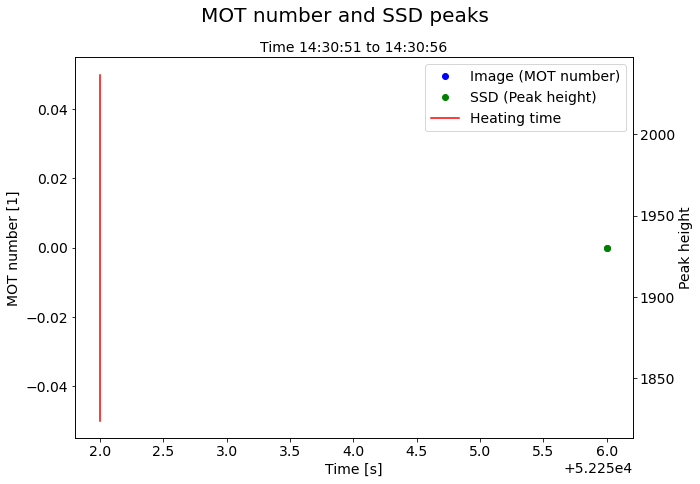

Time at heating: 52573.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 10    52576.242
91    52576.242
Name: seconds, dtype: float64, y_image: 10    1973.336371
91    1973.336371
Name: pulses_peak, dtype: float64


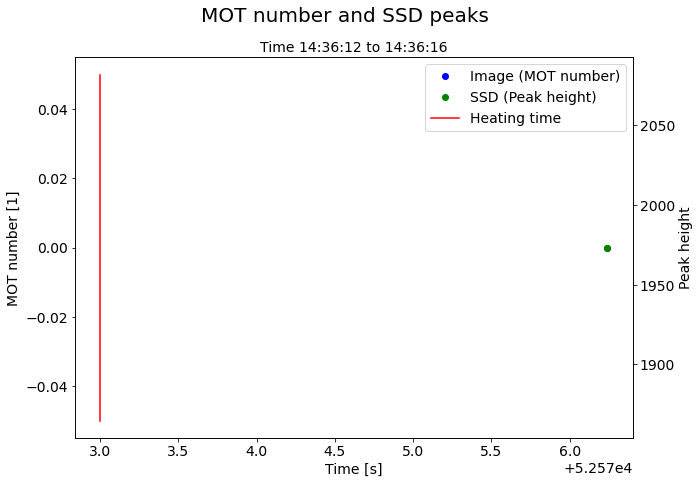

Time at heating: 53930.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 21     53933.047
102    53933.047
Name: seconds, dtype: float64, y_image: 21     223.008374
102    223.008374
Name: pulses_peak, dtype: float64


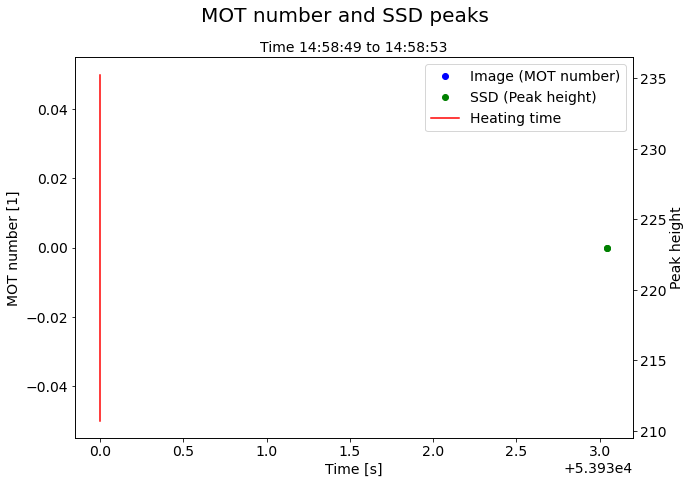

Time at heating: 54207.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 21     53933.047
102    53933.047
Name: seconds, dtype: float64, y_image: 21     223.008374
102    223.008374
Name: pulses_peak, dtype: float64


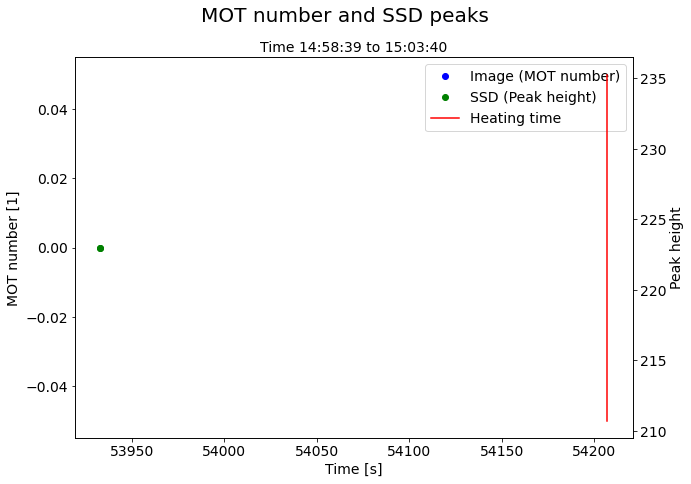

Time at heating: 54761.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 27     54981.851
108    54981.851
Name: seconds, dtype: float64, y_image: 27     153.794073
108    153.794073
Name: pulses_peak, dtype: float64


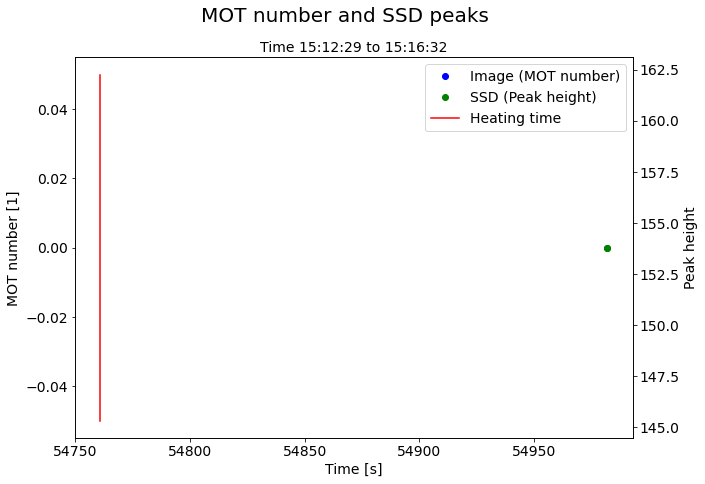

Time at heating: 55020.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 27     54981.851
108    54981.851
Name: seconds, dtype: float64, y_image: 27     153.794073
108    153.794073
Name: pulses_peak, dtype: float64


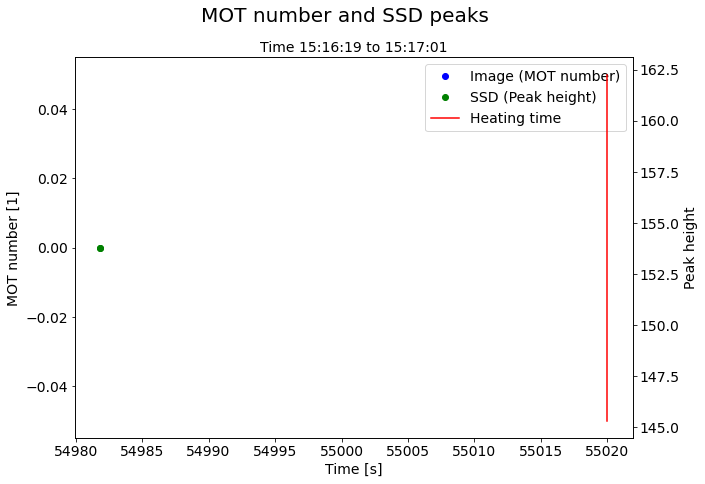

Time at heating: 55692.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 14    55639.667
95    55639.667
Name: seconds, dtype: float64, y_image: 14    193.403763
95    193.403763
Name: pulses_peak, dtype: float64


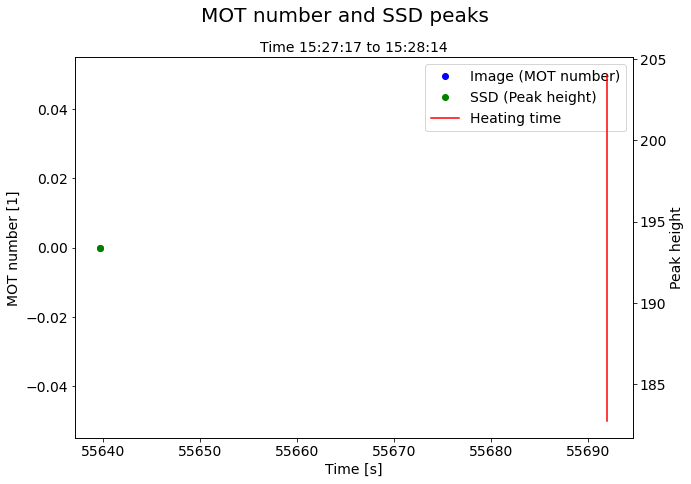

Time at heating: 56126.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 8      56354.485
9      56127.937
17     56086.666
22     56313.375
89     56354.485
90     56127.937
98     56086.666
103    56313.375
Name: seconds, dtype: float64, y_image: 8      2410.415910
9      2083.353337
17      184.624918
22      151.345358
89     2410.415910
90     2083.353337
98      184.624918
103     151.345358
Name: pulses_peak, dtype: float64


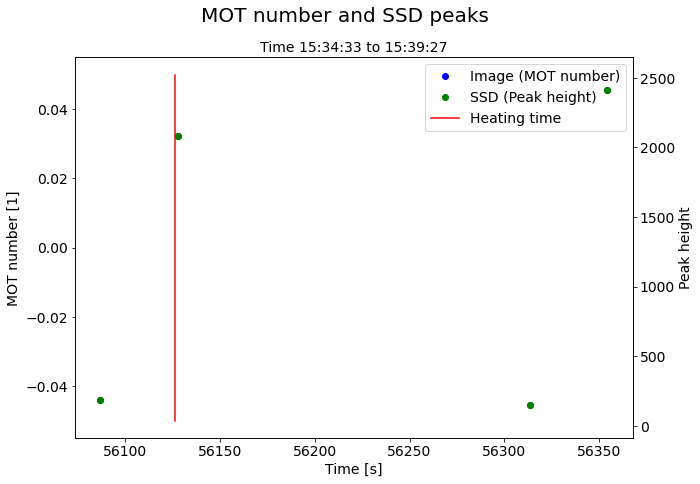

Time at heating: 56352.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 8      56354.485
9      56127.937
17     56086.666
22     56313.375
89     56354.485
90     56127.937
98     56086.666
103    56313.375
Name: seconds, dtype: float64, y_image: 8      2410.415910
9      2083.353337
17      184.624918
22      151.345358
89     2410.415910
90     2083.353337
98      184.624918
103     151.345358
Name: pulses_peak, dtype: float64


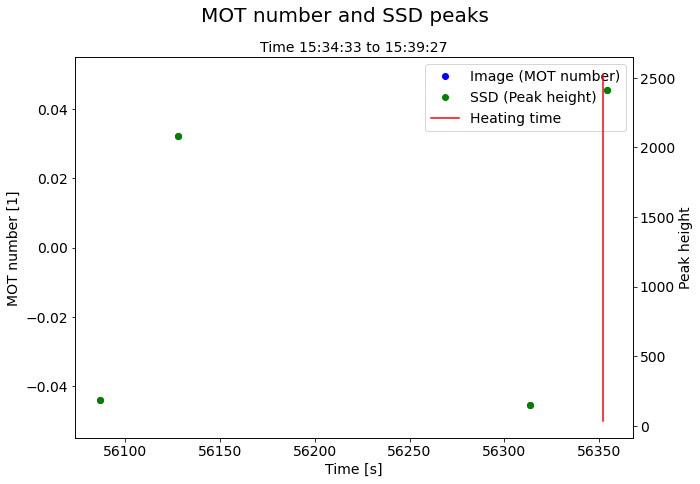

Time at heating: 57762.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 18     57766.531
26     57725.559
99     57766.531
107    57725.559
Name: seconds, dtype: float64, y_image: 18     214.671700
26     143.234438
99     214.671700
107    143.234438
Name: pulses_peak, dtype: float64


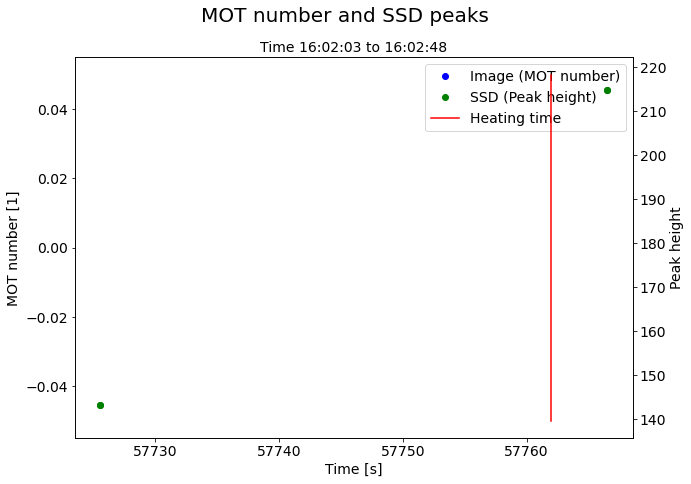

Time at heating: 58119.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 19     58082.910
20     58123.236
100    58082.910
101    58123.236
Name: seconds, dtype: float64, y_image: 19     182.615842
20     239.151019
100    182.615842
101    239.151019
Name: pulses_peak, dtype: float64


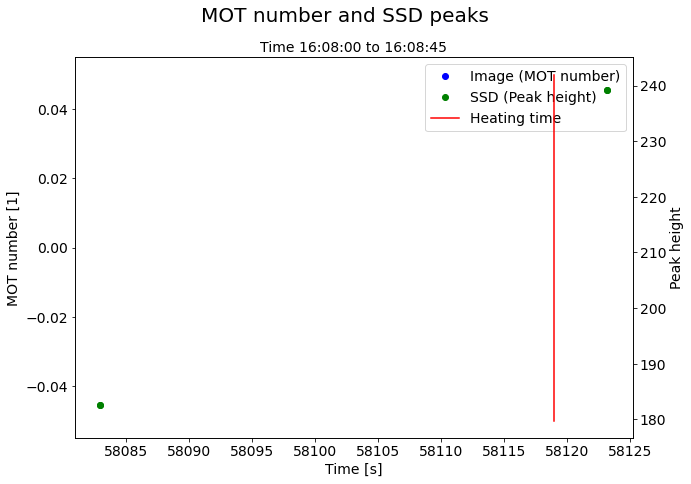

Time at heating: 58536.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 15     58498.287
16     58540.061
24     58592.595
96     58498.287
97     58540.061
105    58592.595
Name: seconds, dtype: float64, y_image: 15     225.061088
16     206.292117
24     233.037653
96     225.061088
97     206.292117
105    233.037653
Name: pulses_peak, dtype: float64


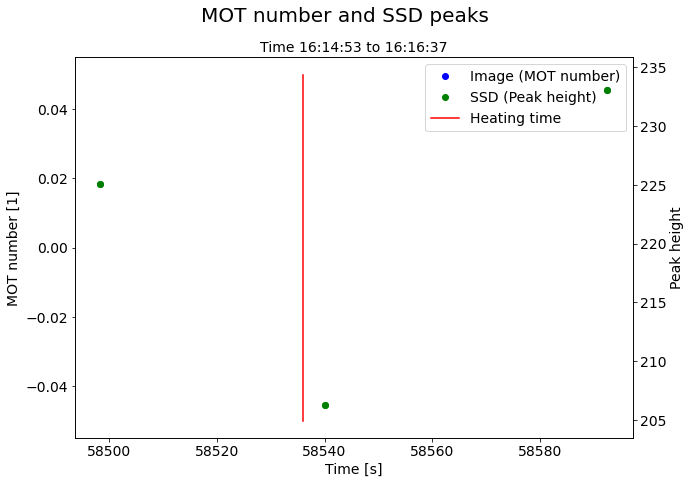

Time at heating: 59180.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 28     59239.003
29     59184.347
31     59141.087
109    59239.003
110    59184.347
112    59141.087
Name: seconds, dtype: float64, y_image: 28     234.586469
29     243.726911
31     131.732879
109    234.586469
110    243.726911
112    131.732879
Name: pulses_peak, dtype: float64


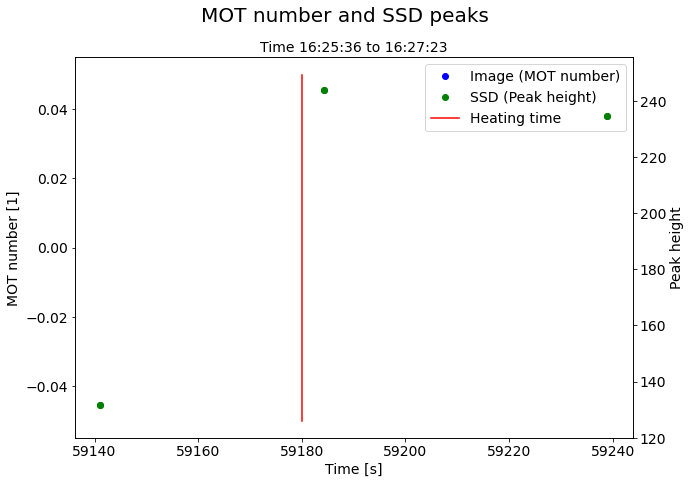

Time at heating: 69025.0
x_image: 155     69079.222
156     69079.695
157     69080.103
158     69080.557
159     69080.984
          ...    
1353    69127.263
1354    69127.689
1355    69128.126
1356    69128.587
1357    69129.019
Name: seconds, Length: 224, dtype: float64, y_image: 155     3.662971e+01
156    -9.662599e+02
157     5.651254e+01
158    -5.444531e+02
159    -1.161262e+03
            ...     
1353    1.207029e+06
1354    1.388790e+06
1355    9.326902e+05
1356    8.062510e+05
1357    1.628008e+06
Name: A, Length: 224, dtype: float64
x_ssd: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: pulses_peak, dtype: float64)


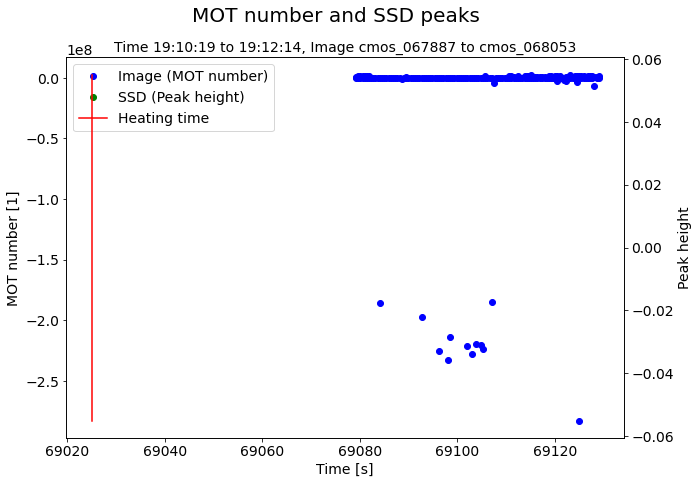

Time at heating: 69052.0
x_image: 155     69079.222
156     69079.695
157     69080.103
158     69080.557
159     69080.984
          ...    
1353    69127.263
1354    69127.689
1355    69128.126
1356    69128.587
1357    69129.019
Name: seconds, Length: 224, dtype: float64, y_image: 155     3.662971e+01
156    -9.662599e+02
157     5.651254e+01
158    -5.444531e+02
159    -1.161262e+03
            ...     
1353    1.207029e+06
1354    1.388790e+06
1355    9.326902e+05
1356    8.062510e+05
1357    1.628008e+06
Name: A, Length: 224, dtype: float64
x_ssd: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: pulses_peak, dtype: float64)


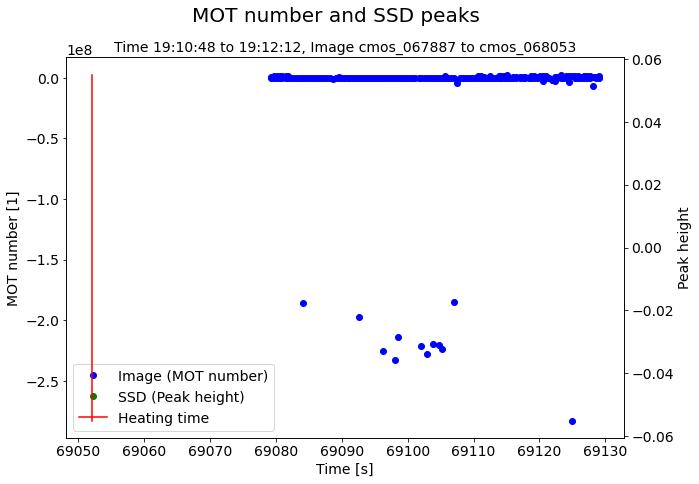

Time at heating: 69488.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 36     69446.923
117    69446.923
Name: seconds, dtype: float64, y_image: 36     354.712412
117    354.712412
Name: pulses_peak, dtype: float64


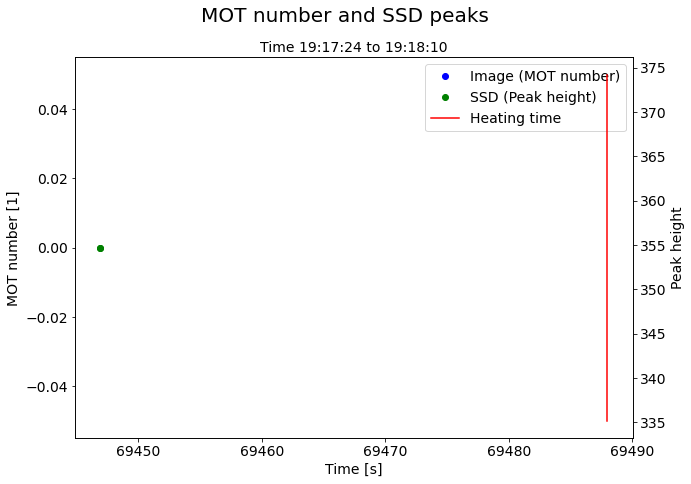

Time at heating: 69515.0
x_image: Series([], Name: seconds, dtype: float64), y_image: Series([], Name: A, dtype: float64)
x_ssd: 36     69446.923
117    69446.923
Name: seconds, dtype: float64, y_image: 36     354.712412
117    354.712412
Name: pulses_peak, dtype: float64


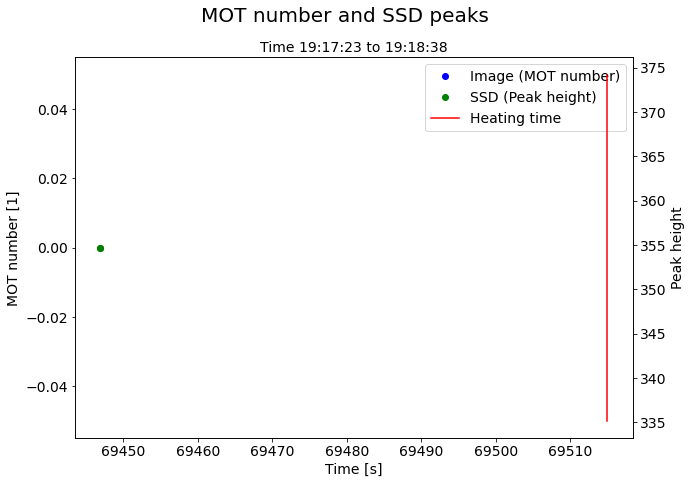

Time at heating: 69947.0
x_image: 267     69996.747
268     69997.160
269     69997.618
270     69998.036
271     69998.474
          ...    
1474    70048.777
1475    70049.230
1476    70049.678
1477    70050.130
1478    70050.572
Name: seconds, Length: 242, dtype: float64, y_image: 267     -665.057520
268       41.460711
269       69.329386
270       21.841075
271     1060.280492
           ...     
1474            NaN
1475            NaN
1476            NaN
1477            NaN
1478            NaN
Name: A, Length: 242, dtype: float64
x_ssd: 58     69906.257
139    69906.257
Name: seconds, dtype: float64, y_image: 58     366.402532
139    366.402532
Name: pulses_peak, dtype: float64


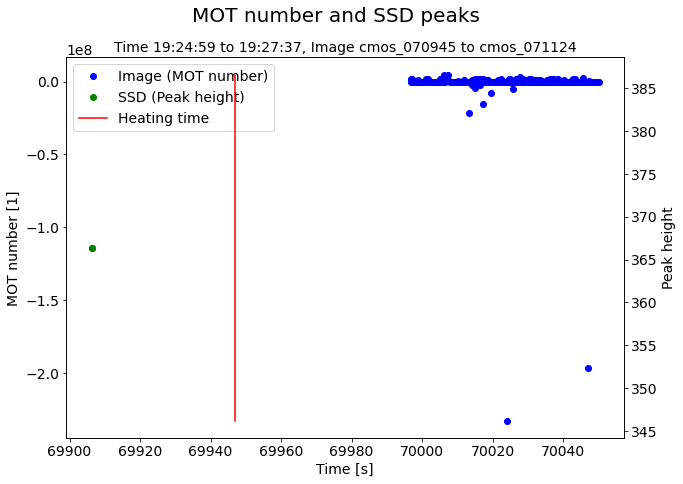

Time at heating: 69974.0
x_image: 267     69996.747
268     69997.160
269     69997.618
270     69998.036
271     69998.474
          ...    
1474    70048.777
1475    70049.230
1476    70049.678
1477    70050.130
1478    70050.572
Name: seconds, Length: 242, dtype: float64, y_image: 267     -665.057520
268       41.460711
269       69.329386
270       21.841075
271     1060.280492
           ...     
1474            NaN
1475            NaN
1476            NaN
1477            NaN
1478            NaN
Name: A, Length: 242, dtype: float64
x_ssd: 58     69906.257
59     70265.311
139    69906.257
140    70265.311
Name: seconds, dtype: float64, y_image: 58     366.402532
59     307.212180
139    366.402532
140    307.212180
Name: pulses_peak, dtype: float64


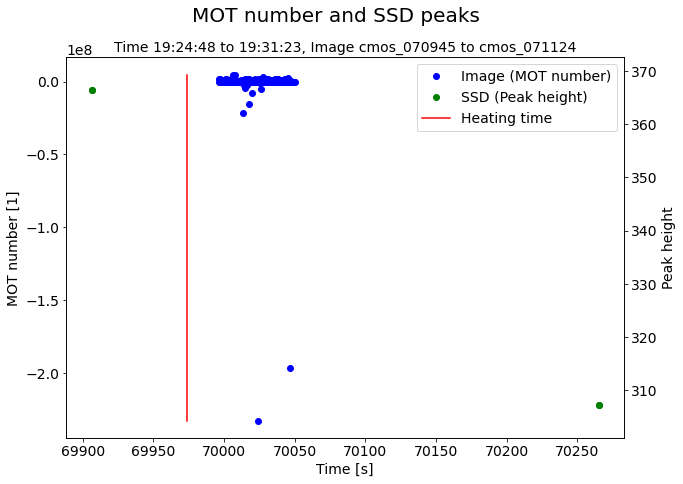

Time at heating: 70304.0
x_image: 284     70004.319
285     70004.755
286     70005.219
287     70005.664
288     70006.119
          ...    
1577    70394.912
1578    70395.346
1579    70395.840
1580    70396.249
1581    70396.694
Name: seconds, Length: 414, dtype: float64, y_image: 284     6.555018e+01
285     7.451533e+01
286     5.918299e+03
287     3.236981e+03
288     8.084193e+03
            ...     
1577    3.726907e+06
1578    2.527212e+06
1579             NaN
1580    6.161136e+06
1581    7.122059e+06
Name: A, Length: 414, dtype: float64
x_ssd: 59     70265.311
140    70265.311
Name: seconds, dtype: float64, y_image: 59     307.21218
140    307.21218
Name: pulses_peak, dtype: float64


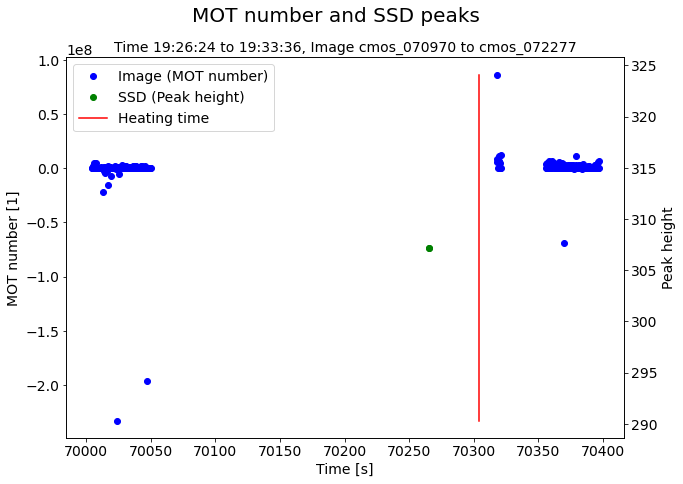

Time at heating: 70331.0
x_image: 344     70031.294
345     70031.753
346     70032.167
347     70032.610
348     70033.062
          ...    
1577    70394.912
1578    70395.346
1579    70395.840
1580    70396.249
1581    70396.694
Name: seconds, Length: 294, dtype: float64, y_image: 344     3.412563e+02
345     2.741887e+03
346     1.259827e+02
347     2.452234e+03
348     2.939139e+02
            ...     
1577    3.726907e+06
1578    2.527212e+06
1579             NaN
1580    6.161136e+06
1581    7.122059e+06
Name: A, Length: 294, dtype: float64
x_ssd: 46     70619.706
59     70265.311
127    70619.706
140    70265.311
Name: seconds, dtype: float64, y_image: 46     277.374107
59     307.212180
127    277.374107
140    307.212180
Name: pulses_peak, dtype: float64


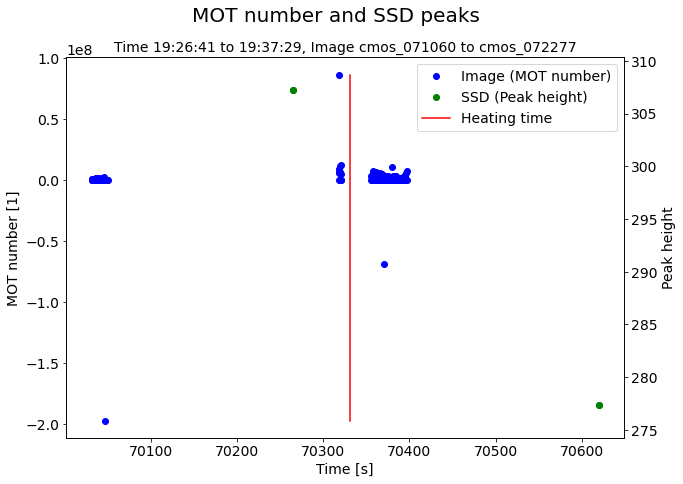

Time at heating: 70661.0
x_image: 408     70361.257
409     70361.728
410     70362.136
411     70362.591
412     70363.015
          ...    
1577    70394.912
1578    70395.346
1579    70395.840
1580    70396.249
1581    70396.694
Name: seconds, Length: 166, dtype: float64, y_image: 408     1.274779e+06
409              NaN
410              NaN
411    -3.163620e+04
412    -1.731148e+03
            ...     
1577    3.726907e+06
1578    2.527212e+06
1579             NaN
1580    6.161136e+06
1581    7.122059e+06
Name: A, Length: 166, dtype: float64
x_ssd: 46     70619.706
127    70619.706
Name: seconds, dtype: float64, y_image: 46     277.374107
127    277.374107
Name: pulses_peak, dtype: float64


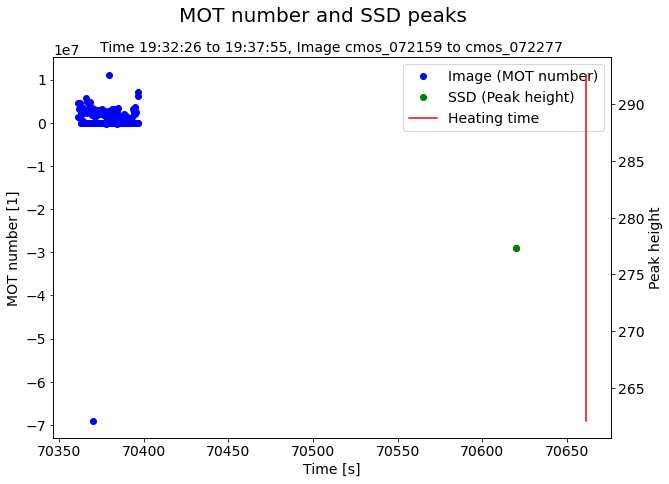

Time at heating: 70688.0
x_image: 471     70388.464
472     70388.870
473     70389.330
474     70389.748
475     70390.151
476     70390.557
477     70390.978
478     70391.396
479     70391.837
480     70392.307
481     70392.774
482     70393.182
483     70393.586
484     70394.051
485     70394.461
486     70394.912
487     70395.346
488     70395.840
489     70396.249
490     70396.694
1562    70388.464
1563    70388.870
1564    70389.330
1565    70389.748
1566    70390.151
1567    70390.557
1568    70390.978
1569    70391.396
1570    70391.837
1571    70392.307
1572    70392.774
1573    70393.182
1574    70393.586
1575    70394.051
1576    70394.461
1577    70394.912
1578    70395.346
1579    70395.840
1580    70396.249
1581    70396.694
Name: seconds, dtype: float64, y_image: 471    -1.306178e+03
472              NaN
473    -7.423550e+02
474    -6.400306e+02
475    -7.628153e+02
476    -8.619076e+02
477     3.711799e+01
478    -1.150240e+03
479    -6.566996e+02
480    -7.165339e

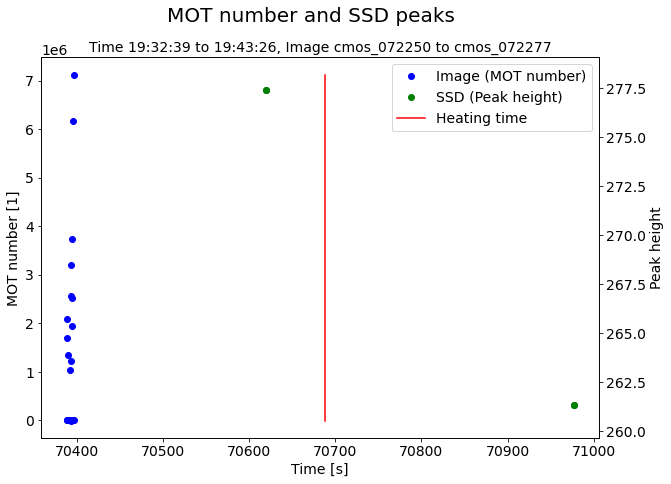

Time at heating: 71018.0
x_image: 491     71068.524
492     71068.995
493     71069.401
494     71069.868
495     71070.273
          ...    
1678    71111.444
1679    71111.871
1680    71112.311
1681    71112.768
1682    71113.214
Name: seconds, Length: 202, dtype: float64, y_image: 491    -1.907687e+07
492    -8.394147e+02
493    -1.833193e+07
494    -9.739622e+02
495     6.642848e+05
            ...     
1678    5.236727e+05
1679             NaN
1680             NaN
1681             NaN
1682             NaN
Name: A, Length: 202, dtype: float64
x_ssd: 47     70976.878
128    70976.878
Name: seconds, dtype: float64, y_image: 47     261.343651
128    261.343651
Name: pulses_peak, dtype: float64


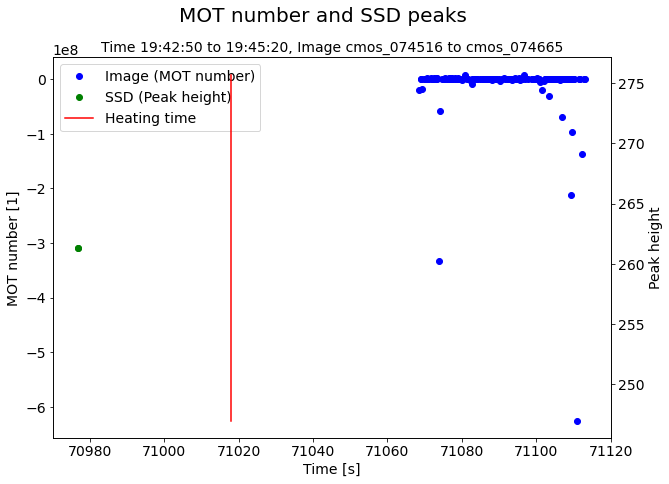

Time at heating: 71045.0
x_image: 491     71068.524
492     71068.995
493     71069.401
494     71069.868
495     71070.273
          ...    
1678    71111.444
1679    71111.871
1680    71112.311
1681    71112.768
1682    71113.214
Name: seconds, Length: 202, dtype: float64, y_image: 491    -1.907687e+07
492    -8.394147e+02
493    -1.833193e+07
494    -9.739622e+02
495     6.642848e+05
            ...     
1678    5.236727e+05
1679             NaN
1680             NaN
1681             NaN
1682             NaN
Name: A, Length: 202, dtype: float64
x_ssd: 34     71333.768
47     70976.878
115    71333.768
128    70976.878
Name: seconds, dtype: float64, y_image: 34     268.072779
47     261.343651
115    268.072779
128    261.343651
Name: pulses_peak, dtype: float64


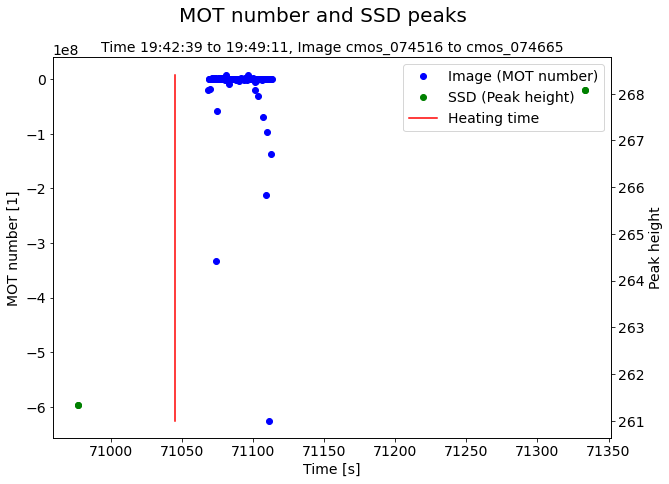

Time at heating: 71375.0
x_image: 506     71075.122
507     71075.590
508     71075.996
509     71076.461
510     71076.868
          ...    
1770    71464.853
1771    71465.293
1772    71465.749
1773    71466.189
1774    71466.647
Name: seconds, Length: 356, dtype: float64, y_image: 506    -2.367805e+03
507    -8.797012e+03
508    -1.077899e+03
509    -2.213248e+03
510     4.667697e+01
            ...     
1770             NaN
1771    2.747356e+06
1772    1.552675e+06
1773             NaN
1774             NaN
Name: A, Length: 356, dtype: float64
x_ssd: 34     71333.768
115    71333.768
Name: seconds, dtype: float64, y_image: 34     268.072779
115    268.072779
Name: pulses_peak, dtype: float64


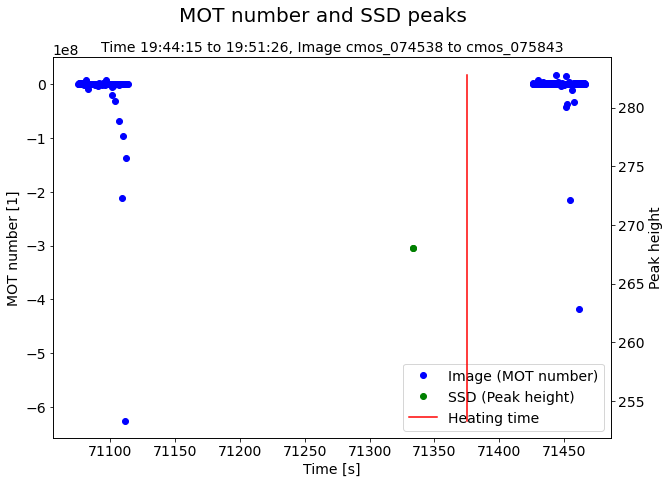

Time at heating: 71403.0
x_image: 569     71103.301
570     71103.770
571     71104.317
572     71104.733
573     71105.200
          ...    
1770    71464.853
1771    71465.293
1772    71465.749
1773    71466.189
1774    71466.647
Name: seconds, Length: 230, dtype: float64, y_image: 569    -3.164724e+07
570    -1.157207e+05
571    -2.251841e+04
572    -1.981864e+03
573    -1.219220e+02
            ...     
1770             NaN
1771    2.747356e+06
1772    1.552675e+06
1773             NaN
1774             NaN
Name: A, Length: 230, dtype: float64
x_ssd: 34     71333.768
35     71691.925
115    71333.768
116    71691.925
Name: seconds, dtype: float64, y_image: 34     268.072779
35     350.095245
115    268.072779
116    350.095245
Name: pulses_peak, dtype: float64


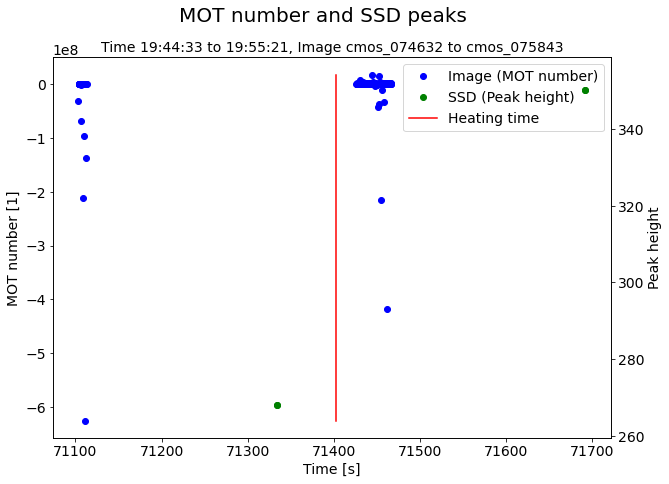

Time at heating: 71733.0
x_image: 609     71433.414
610     71433.847
611     71434.314
612     71434.756
613     71435.214
          ...    
1869    71825.021
1870    71825.458
1871    71825.922
1872    71826.364
1873    71826.819
Name: seconds, Length: 348, dtype: float64, y_image: 609    -7.529179e+02
610    -8.387121e+02
611    -9.535956e+02
612    -1.015840e+03
613    -8.518422e+02
            ...     
1869    1.269706e+06
1870    7.397698e+05
1871    7.531263e+05
1872    8.272426e+05
1873    8.355379e+05
Name: A, Length: 348, dtype: float64
x_ssd: 35     71691.925
72     71850.300
116    71691.925
153    71850.300
Name: seconds, dtype: float64, y_image: 35     350.095245
72      64.168481
116    350.095245
153     64.168481
Name: pulses_peak, dtype: float64


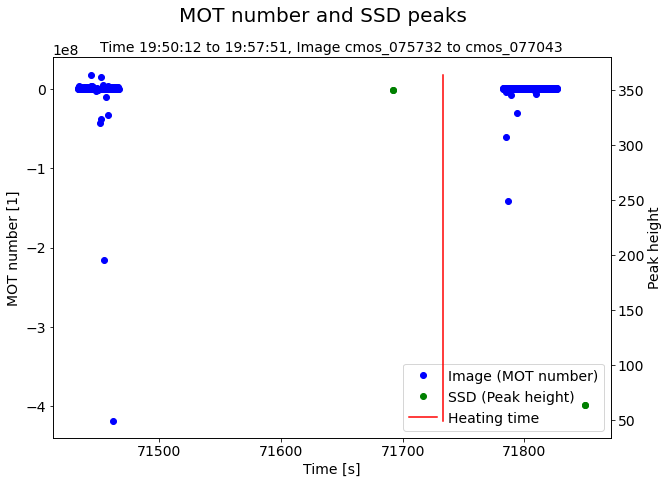

Time at heating: 71760.0
x_image: 669     71460.360
670     71460.792
671     71461.260
672     71461.699
673     71462.160
          ...    
1869    71825.021
1870    71825.458
1871    71825.922
1872    71826.364
1873    71826.819
Name: seconds, Length: 228, dtype: float64, y_image: 669    -7.298666e+02
670     1.444902e+02
671              NaN
672    -4.178511e+08
673    -9.241962e+02
            ...     
1869    1.269706e+06
1870    7.397698e+05
1871    7.531263e+05
1872    8.272426e+05
1873    8.355379e+05
Name: A, Length: 228, dtype: float64
x_ssd: 35     71691.925
72     71850.300
116    71691.925
153    71850.300
Name: seconds, dtype: float64, y_image: 35     350.095245
72      64.168481
116    350.095245
153     64.168481
Name: pulses_peak, dtype: float64


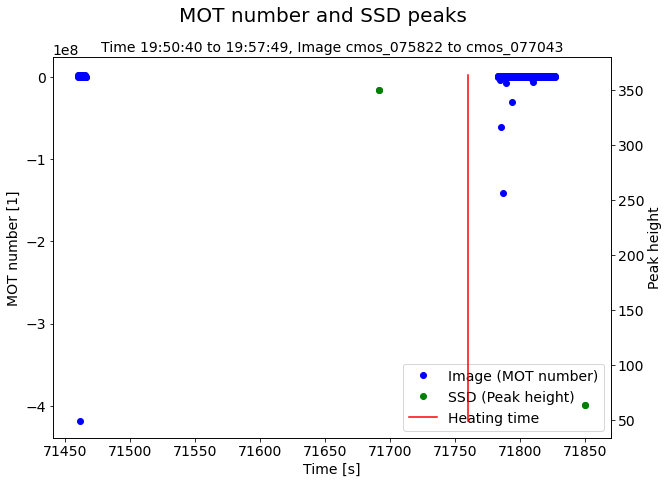

Time at heating: 72188.0
x_image: 783     72241.451
784     72241.899
785     72242.375
786     72242.795
787     72243.266
          ...    
1952    72276.515
1953    72276.952
1954    72277.414
1955    72277.876
1956    72278.310
Name: seconds, Length: 166, dtype: float64, y_image: 783       -926.520957
784      -1137.762862
785     556892.006587
786        108.348629
787       -828.956316
            ...      
1952              NaN
1953    609928.105608
1954    533502.563460
1955              NaN
1956              NaN
Name: A, Length: 166, dtype: float64
x_ssd: 63     72150.171
67     72113.085
69     72256.443
78     72219.837
144    72150.171
148    72113.085
150    72256.443
159    72219.837
Name: seconds, dtype: float64, y_image: 63     352.956247
67      10.766094
69      91.155760
78     112.556297
144    352.956247
148     10.766094
150     91.155760
159    112.556297
Name: pulses_peak, dtype: float64


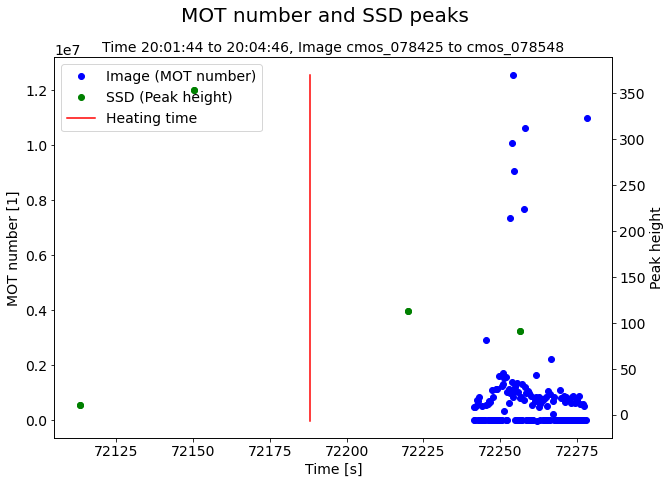

Time at heating: 72215.0
x_image: 783     72241.451
784     72241.899
785     72242.375
786     72242.795
787     72243.266
          ...    
1952    72276.515
1953    72276.952
1954    72277.414
1955    72277.876
1956    72278.310
Name: seconds, Length: 166, dtype: float64, y_image: 783       -926.520957
784      -1137.762862
785     556892.006587
786        108.348629
787       -828.956316
            ...      
1952              NaN
1953    609928.105608
1954    533502.563460
1955              NaN
1956              NaN
Name: A, Length: 166, dtype: float64
x_ssd: 63     72150.171
67     72113.085
69     72256.443
71     72511.638
78     72219.837
144    72150.171
148    72113.085
150    72256.443
152    72511.638
159    72219.837
Name: seconds, dtype: float64, y_image: 63     352.956247
67      10.766094
69      91.155760
71       7.837747
78     112.556297
144    352.956247
148     10.766094
150     91.155760
152      7.837747
159    112.556297
Name: pulses_peak, dtype: float64


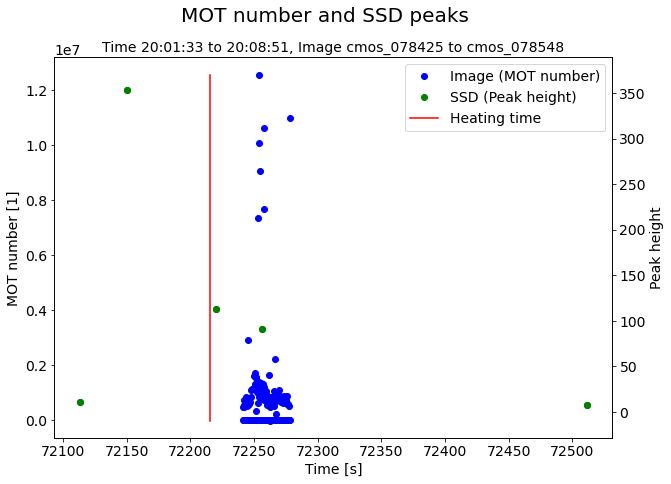

Time at heating: 72578.0
x_image: 865     72278.310
866     72630.014
867     72630.440
868     72630.850
869     72631.255
          ...    
1990    72644.228
1991    72644.694
1992    72645.221
1993    72645.702
1994    72646.188
Name: seconds, Length: 78, dtype: float64, y_image: 865     1.098225e+07
866     1.264897e+02
867     1.641166e+07
868     1.520427e+08
869     1.442726e+06
            ...     
1990    5.445253e+05
1991    6.602715e+05
1992    7.576502e+05
1993    7.423770e+05
1994    5.982047e+05
Name: A, Length: 78, dtype: float64
x_ssd: 62     72538.729
65     72648.123
71     72511.638
76     72610.535
143    72538.729
146    72648.123
152    72511.638
157    72610.535
Name: seconds, dtype: float64, y_image: 62     376.943594
65      98.047275
71       7.837747
76     107.210510
143    376.943594
146     98.047275
152      7.837747
157    107.210510
Name: pulses_peak, dtype: float64


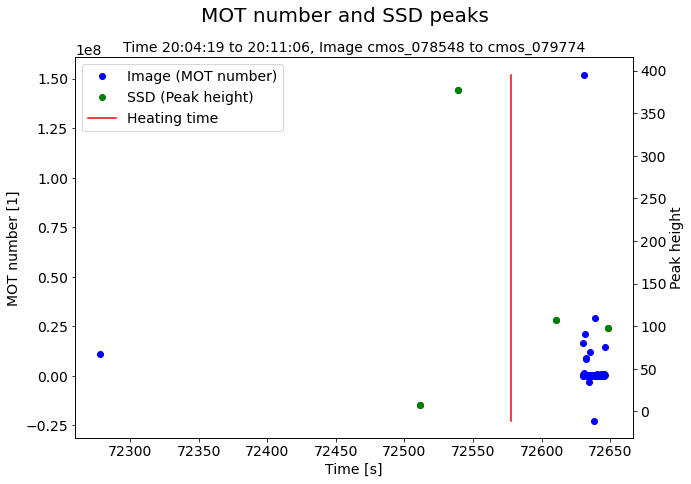

Time at heating: 72605.0
x_image: 866     72630.014
867     72630.440
868     72630.850
869     72631.255
870     72631.667
          ...    
1990    72644.228
1991    72644.694
1992    72645.221
1993    72645.702
1994    72646.188
Name: seconds, Length: 76, dtype: float64, y_image: 866     1.264897e+02
867     1.641166e+07
868     1.520427e+08
869     1.442726e+06
870     2.120025e+07
            ...     
1990    5.445253e+05
1991    6.602715e+05
1992    7.576502e+05
1993    7.423770e+05
1994    5.982047e+05
Name: A, Length: 76, dtype: float64
x_ssd: 62     72538.729
65     72648.123
68     72895.066
71     72511.638
76     72610.535
143    72538.729
146    72648.123
149    72895.066
152    72511.638
157    72610.535
Name: seconds, dtype: float64, y_image: 62     376.943594
65      98.047275
68       6.404767
71       7.837747
76     107.210510
143    376.943594
146     98.047275
149      6.404767
152      7.837747
157    107.210510
Name: pulses_peak, dtype: float64


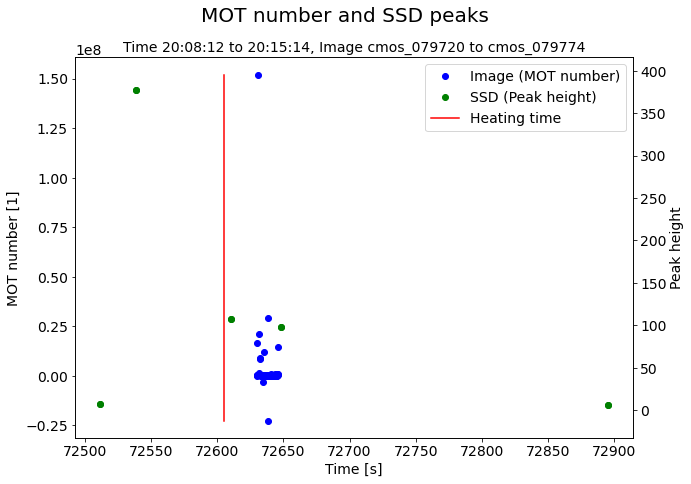

Time at heating: 72963.0
x_image: 904     73011.800
905     73012.295
906     73012.730
907     73013.195
908     73013.613
          ...    
2083    73051.531
2084    73051.963
2085    73052.431
2086    73052.861
2087    73053.335
Name: seconds, Length: 186, dtype: float64, y_image: 904     1.054608e+06
905    -1.341865e+03
906     4.094528e+06
907     5.536824e+04
908     8.083006e+03
            ...     
2083    1.267950e+06
2084    1.322495e+06
2085    8.285535e+05
2086    1.224154e+06
2087    1.372338e+06
Name: A, Length: 186, dtype: float64
x_ssd: 61     72921.621
64     73030.441
68     72895.066
74     73110.776
77     73078.897
142    72921.621
145    73030.441
149    72895.066
155    73110.776
158    73078.897
Name: seconds, dtype: float64, y_image: 61     402.908871
64     113.028036
68       6.404767
74      76.280596
77     190.159347
142    402.908871
145    113.028036
149      6.404767
155     76.280596
158    190.159347
Name: pulses_peak, dtype: float64


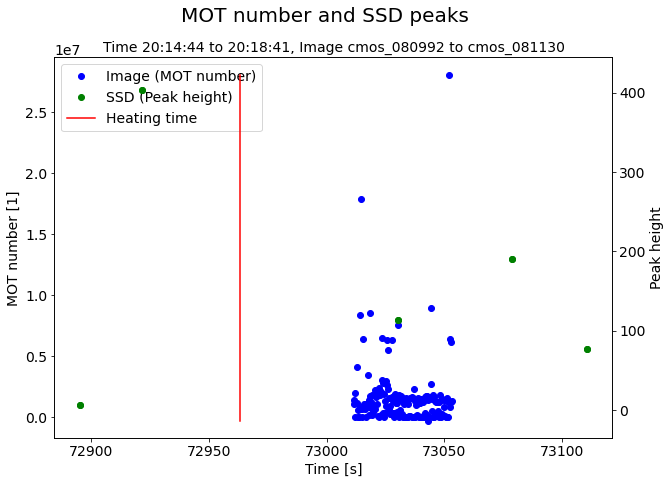

Time at heating: 72990.0
x_image: 904     73011.800
905     73012.295
906     73012.730
907     73013.195
908     73013.613
          ...    
2083    73051.531
2084    73051.963
2085    73052.431
2086    73052.861
2087    73053.335
Name: seconds, Length: 186, dtype: float64, y_image: 904     1.054608e+06
905    -1.341865e+03
906     4.094528e+06
907     5.536824e+04
908     8.083006e+03
            ...     
2083    1.267950e+06
2084    1.322495e+06
2085    8.285535e+05
2086    1.224154e+06
2087    1.372338e+06
Name: A, Length: 186, dtype: float64
x_ssd: 61     72921.621
64     73030.441
68     72895.066
74     73110.776
77     73078.897
142    72921.621
145    73030.441
149    72895.066
155    73110.776
158    73078.897
Name: seconds, dtype: float64, y_image: 61     402.908871
64     113.028036
68       6.404767
74      76.280596
77     190.159347
142    402.908871
145    113.028036
149      6.404767
155     76.280596
158    190.159347
Name: pulses_peak, dtype: float64


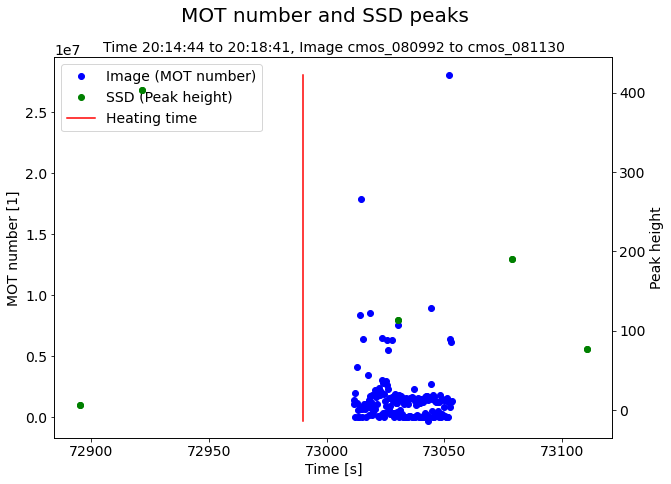

Time at heating: 73421.0
x_image: 997     73469.996
998     73470.437
999     73470.900
1000    73471.355
1001    73471.797
          ...    
2177    73509.967
2178    73510.421
2179    73510.873
2180    73511.319
2181    73511.777
Name: seconds, Length: 188, dtype: float64, y_image: 997      -1592.018500
998      -1525.470328
999      -1157.645270
1000      -933.941520
1001     -1385.979457
            ...      
2177    722842.089023
2178    527588.255079
2179    840254.437984
2180    841811.235441
2181    879399.301429
Name: A, Length: 188, dtype: float64
x_ssd: 60     73379.880
66     73492.543
70     73345.537
73     73522.638
75     73561.655
141    73379.880
147    73492.543
151    73345.537
154    73522.638
156    73561.655
Name: seconds, dtype: float64, y_image: 60     336.527368
66      87.996168
70       8.318709
73      90.995661
75      61.446297
141    336.527368
147     87.996168
151      8.318709
154     90.995661
156     61.446297
Name: pulses_peak, dtype: float64


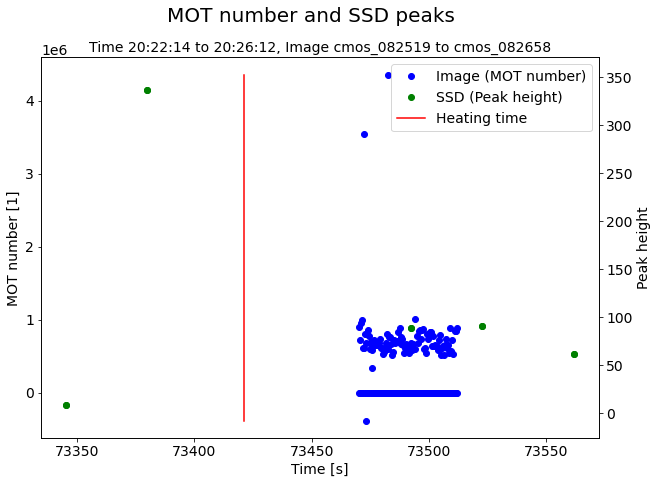

Time at heating: 73448.0
x_image: 997     73469.996
998     73470.437
999     73470.900
1000    73471.355
1001    73471.797
          ...    
2177    73509.967
2178    73510.421
2179    73510.873
2180    73511.319
2181    73511.777
Name: seconds, Length: 188, dtype: float64, y_image: 997      -1592.018500
998      -1525.470328
999      -1157.645270
1000      -933.941520
1001     -1385.979457
            ...      
2177    722842.089023
2178    527588.255079
2179    840254.437984
2180    841811.235441
2181    879399.301429
Name: A, Length: 188, dtype: float64
x_ssd: 60     73379.880
66     73492.543
70     73345.537
73     73522.638
75     73561.655
141    73379.880
147    73492.543
151    73345.537
154    73522.638
156    73561.655
Name: seconds, dtype: float64, y_image: 60     336.527368
66      87.996168
70       8.318709
73      90.995661
75      61.446297
141    336.527368
147     87.996168
151      8.318709
154     90.995661
156     61.446297
Name: pulses_peak, dtype: float64


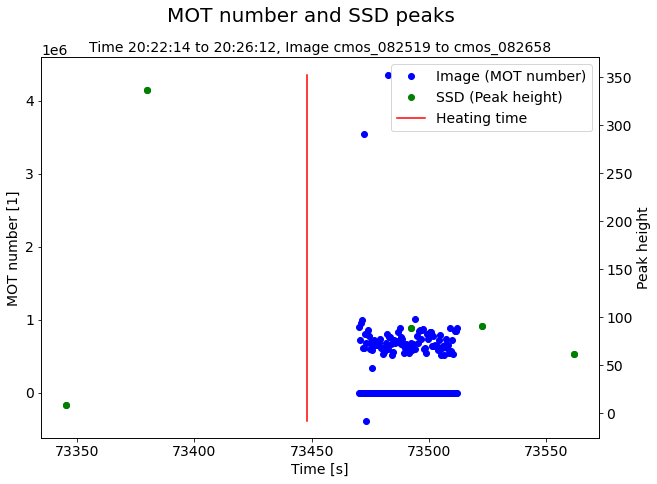

In [91]:
for t, image_df, ssd_df in zip(ht_df_18["seconds"], queried_image_dfs, queried_ssd_dfs): 

  # Create plot
  fig, ax = plt.subplots()

  # Image
  x_image = image_df["seconds"]
  y_image = image_df["A"]
  line1, = ax.plot(x_image, y_image, "bo", label="Image (MOT number)")
  ax.set_xlabel("Time [s]", fontsize = 14)
  ax.set_ylabel("MOT number [1]", fontsize = 14)

  # SSD
  x_ssd = ssd_df["seconds"]
  y_ssd = ssd_df["pulses_peak"]
  ax2 = ax.twinx()
  line2, = ax2.plot(x_ssd, y_ssd, "go", label="SSD (Peak height)")
  ax2.set_ylabel("Peak height", fontsize=14)

  # Heating time
  ymin, ymax = ax2.get_ylim()
  line3, = ax2.plot([t, t], [ymin, ymax], "r-", label="Heating time")
  
  # Title
  xmin, xmax = ax2.get_xlim()
  title = f"Time {datetime.timedelta(seconds=int(xmin))} to {datetime.timedelta(seconds=int(xmax))}"
  if len(image_df.index) > 0:
    first_filename = image_df.iloc[0]["filename"]
    last_filename = image_df.iloc[-1]["filename"]
    title = title + f", Image {first_filename} to {last_filename}"
  plt.title(title, fontsize=14)

  # Subtitle
  fig.suptitle(f'MOT number and SSD peaks', fontsize=20)

  # Print
  print(f"Time at heating: {t}")
  print(f"x_image: {x_image}, y_image: {y_image}")
  print(f"x_ssd: {x_ssd}, y_image: {y_ssd}")

  # Legend
  ax.legend(handles=[line1, line2, line3])

  # Save
  fname = filepath_drive + "/results" + "/Sunday_Fr_1300_to_2100_min_signal0_nref500_deadp2" + f"/union_plot_{datetime.timedelta(seconds=int(t))}.png"
  fig.savefig(fname=fname)

  # Show
  plt.show()



### Conclusion Sunday
The following times are promosing for finding the MOT signal: 


In [92]:
promising_times_ssd = [52573.0, 53930.0, 56126.0, 56354.0, 57762.0, 58119.0, 58536.0, 59180.0]
[str(datetime.timedelta(seconds=s)) for s in promising_times_ssd]


['14:36:13',
 '14:58:50',
 '15:35:26',
 '15:39:14',
 '16:02:42',
 '16:08:39',
 '16:15:36',
 '16:26:20']

In [93]:
promising_times_image = [70315.0, 70380, 72260, 72630, 73010, 73460]
[str(datetime.timedelta(seconds=s)) for s in promising_times_image]

['19:31:55', '19:33:00', '20:04:20', '20:10:30', '20:16:50', '20:24:20']

## Visualization Monday
We now plot the data together to check if we can see the MOT signal from the analysis results. Before we did this for Sunday, now we do it for Monday, 19. October 2022. 

In [94]:
# Identify time windows
time_diff = 5 * 60 # [s] 5 minutes
time_windows = [(t - time_diff, t + time_diff ) for t in ht_df_19["seconds"]]
time_windows

[(51276.0, 51876.0),
 (51304.0, 51904.0),
 (51731.0, 52331.0),
 (51758.0, 52358.0),
 (52098.0, 52698.0),
 (52125.0, 52725.0),
 (52544.0, 53144.0),
 (52572.0, 53172.0),
 (52884.0, 53484.0),
 (52911.0, 53511.0),
 (53223.0, 53823.0),
 (53251.0, 53851.0),
 (55539.0, 56139.0),
 (55567.0, 56167.0),
 (56392.0, 56992.0),
 (56419.0, 57019.0),
 (56732.0, 57332.0),
 (56760.0, 57360.0),
 (57122.0, 57722.0),
 (57798.0, 58398.0),
 (58617.0, 59217.0),
 (59243.0, 59843.0),
 (59958.0, 60558.0),
 (60517.0, 61117.0),
 (61064.0, 61664.0),
 (61641.0, 62241.0),
 (61958.0, 62558.0),
 (62568.0, 63168.0),
 (62595.0, 63195.0),
 (63019.0, 63619.0),
 (63046.0, 63646.0),
 (63455.0, 64055.0),
 (63483.0, 64083.0),
 (64118.0, 64718.0),
 (64145.0, 64745.0),
 (64534.0, 65134.0),
 (64561.0, 65161.0),
 (68226.0, 68826.0),
 (68253.0, 68853.0),
 (69809.0, 70409.0),
 (69837.0, 70437.0),
 (70270.0, 70870.0),
 (70297.0, 70897.0),
 (71715.0, 72315.0),
 (71753.0, 72353.0),
 (73177.0, 73777.0),
 (73225.0, 73825.0),
 (74255.0, 74

In [95]:
# Query
queried_image_dfs = [image_df_19.query(f"seconds > {tw[0]}").query(f"seconds < {tw[1]}") for tw in time_windows]
queried_ssd_dfs = [ssd_df_19.query(f"seconds > {tw[0]}").query(f"seconds < {tw[1]}") for tw in time_windows]

In [96]:
for t, image_df, ssd_df in zip(ht_df_19["seconds"], queried_image_dfs, queried_ssd_dfs): 

  # Create plot
  fig,ax = plt.subplots()

  # Image
  x_image = image_df["seconds"]
  y_image = image_df["A"]
  line1, = ax.plot(x_image, y_image, "bo", label="Image (MOT number)")
  ax.set_xlabel("Time [s]", fontsize = 14)
  ax.set_ylabel("MOT number [1]", fontsize = 14)

  # SSD
  x_ssd = ssd_df["seconds"]
  y_ssd = ssd_df["pulses_peak"]
  ax2 = ax.twinx()
  line2, = ax2.plot(x_ssd, y_ssd, "go", label="SSD (Peak height)")
  ax2.set_ylabel("Peak height", fontsize=14)

  # Heating time
  ymin, ymax = ax2.get_ylim()
  line3, = ax2.plot([t, t], [ymin, ymax], "r-", label="Heating time")

  # Title
  title = f"Time {datetime.timedelta(seconds=int(xmin))} to {datetime.timedelta(seconds=int(xmax))}"
  if len(image_df.index) > 0:
    first_filename = image_df.iloc[0]["filename"]
    last_filename = image_df.iloc[-1]["filename"]
    title = title + f", Image {first_filename} to {last_filename}"
  plt.title(title, fontsize=14)

  # Subtitle
  xmin, xmax = ax2.get_xlim()
  fig.suptitle(f'MOT number and SSD peaks', fontsize=20)

  # Print
  print(f"Time at heating: {t}")
  print(f"x_image: {x_image}, y_image: {y_image}")
  print(f"x_ssd: {x_ssd}, y_image: {y_ssd}")

  # Legend
  ax.legend(handles=[line1, line2, line3])

  # Save
  fname = filepath_drive + "/results" + "/Monday_Fr_1800_2100_min_signal0_nref20_deadp2" + f"/union_plot_{datetime.timedelta(seconds=int(t))}.png"
  fig.savefig(fname=fname)

  # Show
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Conclusion Monday
The following times are promosing for finding the MOT signal:

In [97]:
promising_times_ssd = [57000, 57420]
[str(datetime.timedelta(seconds=s)) for s in promising_times_ssd]

['15:50:00', '15:57:00']

In [98]:
promising_times_image = [68575, 68625, 70160, 70640, 72080, 73550, 74625, 75140, 75520]
[str(datetime.timedelta(seconds=s)) for s in promising_times_image]

['19:02:55',
 '19:03:45',
 '19:29:20',
 '19:37:20',
 '20:01:20',
 '20:25:50',
 '20:43:45',
 '20:52:20',
 '20:58:40']

In [99]:
!git status

On branch union
Your branch is up to date with 'origin/union'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../src/notebooks/source_union.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
